# Análisis Exploratorio de Datos - Data set de OpenSky Network

En este apartado se analizan los datos ya procesados y limpios para responder a las cuestiones inicialmente formuladas sobre el impacto del Covid-19 en el tráfico aéreo español. Para ello, el análisis se centrará en los vuelos que tienen como origen, destino o ambos, una localidad del territorio español. Se descubrirá el comportamiento de los vuelos durante los años 2019 y 2020 con datos reales de los vuelos. 

Para este análisis, se asumirán los dos tipos de vuelos más comunes, comerciales y de pasajeros. Existen vuelos militares, vuelos de aerolíneas privadas, vuelos gubernamentales, entre otros, sin embargo, estas tipologías de vuelos han sido procesadas en el tratamiento inicial de datos y representan una cantidad residual en los resultados finales.

## Lectura de datos

Se empezará con la exploración de cada una de las variables que componen el conjunto de datos. Al reducir el espectro del análisis de los vuelos a solo los vuelos con origen o destino en España, se puede cargar toda la información necesaria en un solo archivo y trabajar con un único data set, facilitando así el análisis de los datos.

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import reverse_geocoder as rg
import math

In [3]:
# read all data files and make unique dataframe
df_esp = pd.DataFrame()
for i in range(28):
    df = pd.read_csv(('input_data_clean/{}_clean.csv.gz').format(i+1), sep=',', encoding='utf-8',)
    print('FILE: ',i+1,'-DONE- ###############################')
    esp_fl = df[(df['origin_country']=='Spain') | (df['destination_country']=='Spain')]
    df_esp = pd.concat([df_esp,esp_fl], axis=0,)

# rename some columns
df_esp.columns = ['date', 'latitude_1', 'longitude_1', 'latitude_2', 'longitude_2',
                  'airline', 'airline_country', 'origin_region', 'destination_region',
                  'origin_city', 'destination_city', 'origin_continent', 'origin_country',
                  'destination_continent', 'destination_country']

# create new useful columns
df_esp.reset_index(drop=True, inplace=True)
df_esp['date'] = pd.to_datetime(df_esp['date'])
df_esp['year_'] = df_esp['date'].apply(lambda x: x.year)
df_esp['month_'] = df_esp['date'].apply(lambda x: x.month)
df_esp['day_'] = df_esp['date'].apply(lambda x: x.day)
df_esp['flights'] = 1

# save result file
df_esp.to_csv('input_data_clean/all_spain_flights.csv.gz', sep=',', index=False,encoding='utf-8')

FILE:  1 -DONE- ###############################
FILE:  2 -DONE- ###############################
FILE:  3 -DONE- ###############################
FILE:  4 -DONE- ###############################
FILE:  5 -DONE- ###############################
FILE:  6 -DONE- ###############################
FILE:  7 -DONE- ###############################
FILE:  8 -DONE- ###############################
FILE:  9 -DONE- ###############################
FILE:  10 -DONE- ###############################
FILE:  11 -DONE- ###############################
FILE:  12 -DONE- ###############################
FILE:  13 -DONE- ###############################
FILE:  14 -DONE- ###############################
FILE:  15 -DONE- ###############################
FILE:  16 -DONE- ###############################
FILE:  17 -DONE- ###############################
FILE:  18 -DONE- ###############################
FILE:  19 -DONE- ###############################
FILE:  20 -DONE- ###############################
FILE:  21 -DONE- ############

In [4]:
df_esp = pd.read_csv('input_data_clean/all_spain_flights.csv.gz', sep=',', encoding='utf-8',)
df_esp['date'] = pd.to_datetime(df_esp['date'])

In [5]:
df_esp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987732 entries, 0 to 1987731
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date                   datetime64[ns]
 1   latitude_1             float64       
 2   longitude_1            float64       
 3   latitude_2             float64       
 4   longitude_2            float64       
 5   airline                object        
 6   airline_country        object        
 7   origin_region          object        
 8   destination_region     object        
 9   origin_city            object        
 10  destination_city       object        
 11  origin_continent       object        
 12  origin_country         object        
 13  destination_continent  object        
 14  destination_country    object        
 15  year_                  int64         
 16  month_                 int64         
 17  day_                   int64         
 18  flights               

Se ha añadido el campo ***flights*** con un **1** en cada registro, de tal manera que será la columna usada para computar el vuelo y agregar valores entre vuelos con características similares.

Asimismo, se han añadido campos para el año, mes y día del vuelo (***year_, month_, day_***)

In [6]:
pd.set_option('max_columns', None)
df_esp.head()

,date,latitude_1,longitude_1,latitude_2,longitude_2,airline,airline_country,origin_region,destination_region,origin_city,destination_city,origin_continent,origin_country,destination_continent,destination_country,year_,month_,day_,flights
0,2019-01-01,-37.692123,144.841997,41.036124,2.063557,Air China,China,Victoria,Catalonia,Melbourne,Barcelona,Oceania,Australia,Europe,Spain,2019,1,1,1
1,2019-01-02,60.626541,41.002776,40.483418,-3.546173,Air China,China,Arkhangelskaya,Madrid,Podyuga,Madrid,Europe,Russian Federation,Europe,Spain,2019,1,2,1
2,2019-01-02,40.535614,-3.558960,54.301835,90.041282,Air China,China,Madrid,Khakasiya,Madrid,Tuim,Europe,Spain,Europe,Russian Federation,2019,1,2,1
3,2019-01-03,58.353378,42.201942,40.486237,-3.549037,Air China,China,Kostroma,Madrid,Galich,Madrid,Europe,Russian Federation,Europe,Spain,2019,1,3,1
4,2019-01-04,-37.690430,144.841705,41.064423,2.037415,Air China,China,Victoria,Catalonia,Melbourne,Barcelona,Oceania,Australia,Europe,Spain,2019,1,4,1


Por otro lado, se realiza la carga de un data set con información sobre los casos Covid-19 en diferentes países europeos para ver la correlación entre la cantidad de vuelos entre paises y los casos de covid en cada uno. Para ello, se ha creado un archivo con los casos de covid diarios por país sacados de la siguiente fuente https://ourworldindata.org/. Los países son **España, Francia, Alemania, Holanda, Italia y Portugal**; para cada uno de ellos se ha calculado la incidencia acumulada a 14 días con los datos públicos de la fuente y el censo de la población del país a fecha 1 de Enero de ese año. El periodo de estudio va desde Febrero de 2019 a Abril de 2021, ambos incluidos.

In [22]:
df_covid_eu = pd.read_csv('aux_files/covid_cases_hist.csv', sep=';', index_col='date', encoding='utf-8',parse_dates=True,dayfirst=True)

In [23]:
df_covid_eu.head()

,cases_esp,cases_14d_esp,cases_14d_100k_hab_esp,cases_uk,cases_14d_uk,cases_14d_100k_hab_uk,cases_fr,cases_14d_fr,cases_14d_100k_hab_fr,cases_gr,...,cases_14d_100k_hab_gr,cases_it,cases_14d_it,cases_14d_100k_hab_it,cases_nt,cases_14d_nt,cases_14d_100k_hab_nt,cases_pt,cases_14d_pt,cases_14d_100k_hab_pt
date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,16,0,0.0,0,0,0.0,1,0,0.0,3,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
2020-02-02,10,0,0.0,0,0,0.0,0,0,0.0,2,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
2020-02-03,11,0,0.0,0,0,0.0,0,0,0.0,2,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
2020-02-04,9,0,0.0,0,0,0.0,0,0,0.0,0,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
2020-02-05,6,0,0.0,0,0,0.0,0,0,0.0,0,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0


In [24]:
df_covid_eu = df_covid_eu[['cases_14d_100k_hab_esp', 
                           'cases_14d_100k_hab_uk', 
                           'cases_14d_100k_hab_fr', 
                           'cases_14d_100k_hab_gr', 
                           'cases_14d_100k_hab_it', 
                           'cases_14d_100k_hab_nt', 
                           'cases_14d_100k_hab_pt']]

In [25]:
df_covid_eu.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    455 non-null    datetime64[ns]
 1   cases_14d_100k_hab_esp  455 non-null    float64       
 2   cases_14d_100k_hab_uk   455 non-null    float64       
 3   cases_14d_100k_hab_fr   455 non-null    float64       
 4   cases_14d_100k_hab_gr   455 non-null    float64       
 5   cases_14d_100k_hab_it   455 non-null    float64       
 6   cases_14d_100k_hab_nt   455 non-null    float64       
 7   cases_14d_100k_hab_pt   455 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 28.6 KB


## Limpieza de datos y EDA

Se comprueba la cantidad de nulos que existen en el data set de trabajo. Se identifica la presencia de un porcentaje muy pequeño de valores con nulos, solamente en las columnas de ***origin y destination*** de ***_region y _city***. Se analiza a continuación los registros que faltan y si alguno de estos nulos corresponde a localidades del territorio español.

In [72]:
print('Porcentaje de nulos por columna:')
for e in df_esp.columns: 
    print(e,np.round(df_esp[e].isnull().sum()/len(df_esp)*100,5),'%')

Porcentaje de nulos por columna:
date 0.0 %
latitude_1 0.0 %
longitude_1 0.0 %
latitude_2 0.00116 %
longitude_2 0.00116 %
airline 0.0 %
airline_country 0.0 %
origin_region 0.1222 %
destination_region 0.15259 %
origin_city 0.19711 %
destination_city 0.26769 %
origin_continent 0.0 %
origin_country 0.0 %
destination_continent 0.0 %
destination_country 0.0 %
year_ 0.0 %
month_ 0.0 %
day_ 0.0 %
flights 0.0 %


De una forma rápida, se puede realizar un análisis exploratorio de los datos mediante el uso de librerías específicas, como puede ser la ***pandas-profiling*** la cual, utilizando un data frame como input, permite obtener información descriptiva y detallada de cada una de las variables que lo componen. Así pues, se pueden observar la cantidad de nulos en cada una de las variables, valores más frecuentes, percentiles, medias y demás indicadores estadísticos así como correlación entre variables y registros duplicados, entre otros.

In [4]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_esp, title="Pandas Profiling Report", explorative=True)

In [5]:
profile.to_widgets()

En este punto, se identifica la presencia de registros de vuelos repetidos debido a la base de datos de códigos de aerolíneas detalladas en el primer *notebook* donde se ejemplificó el paso a paso de la limpieza de datos. La existencia de areolíneas con el **código ICAO repetido** como se explicó previamente, resulta en una mayor cantidad de registros de vuelos para esos códigos compartidos. Analizando el listado de filas duplicadas, se ha conseguido ver cuales eran estos códigos y en función de eso se ha modificado la base de datos de las aerolíneas.

Se comprueba a continuación el número de duplicados de nuestro data set completo y se identifica que solamente tenemos una fila duplicada que tiene como origen la funte de datos inicial. Se procede a su eliminación.

In [11]:
drop_duplicate_rows = df_esp[df_esp.duplicated(subset=None)].index
df_esp.drop(drop_duplicate_rows, inplace=True)
df_esp[df_esp.duplicated(subset=None)]

,date,latitude_1,longitude_1,latitude_2,longitude_2,airline,airline_country,origin_region,destination_region,origin_city,destination_city,origin_continent,origin_country,destination_continent,destination_country,year_,month_,day_,flights


Se eliminan las filas con alguna de las regiones de origen o destino que no pertenecen a ninguna de las comunidades autónomas de España. En total, se obtienen 451 registros con alguna región no correspondiente a las comunidades autónomas españolas.

In [12]:
CCAA = ['Madrid', 'Catalonia', 'Galicia', 'Andalusia', 'Valencia',
       'Balearic Islands', 'Canary Islands', 'Basque Country',
       'Castille and Leon', 'Aragon', 'Asturias', 'Castille-La Mancha',
       'Murcia', 'Navarre', 'Cantabria', 'Extremadura', 'Melilla',
       'Ceuta', 'La Rioja']

del_rows_1 = df_esp[(df_esp['origin_country']=='Spain') & (~df_esp['origin_region'].isin(CCAA))].index
del_rows_2 = df_esp[(df_esp['destination_country']=='Spain') & (~df_esp['destination_region'].isin(CCAA))].index

s1 = set(del_rows_1)
s2 = set(del_rows_2)
del_rows_ccaa = list(s1.union(s2))
df_esp.drop(del_rows_ccaa, inplace=True)

In [13]:
df_esp.to_csv('input_data_clean/all_spain_flights_clean.csv.gz', sep=';', index=False,encoding='utf-8')

# Data Analysis

In [3]:
df_esp = pd.read_csv('input_data_clean/all_spain_flights_clean.csv.gz', sep=';', encoding='utf-8',)
df_esp['date'] = pd.to_datetime(df_esp['date'])

## Top airline companies

Se muestra a continuación, una comparación de vuelos realizados por las diferentes aerolíneas entre ambos años. Se puede comprobar como de un año a otro, **el número de vuelos** llevados a cabo por la mayoría de las principales compañías aéreas que operan en España ha **disminuido en más de un 50% respecto al año anterior**. 

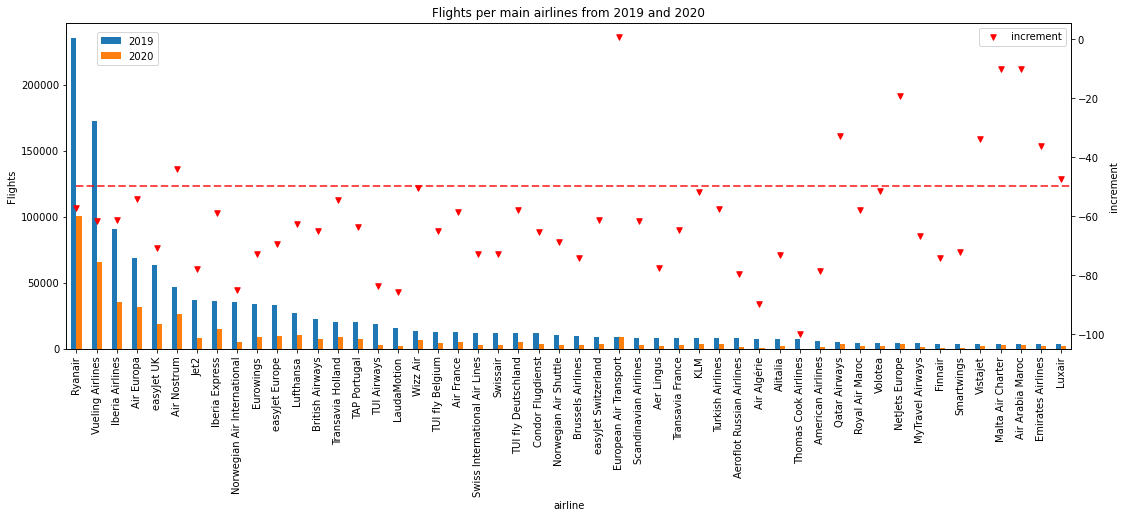

In [4]:
table_airlines = pd.pivot_table(df_esp[df_esp['year_']!=2021],values='flights',index=['airline'],columns=['year_'],aggfunc='sum')
table_airlines = table_airlines.sort_values(2019,ascending=False).iloc[0:50].fillna(0)
table_airlines.reset_index(inplace=True)
table_airlines['increment'] = np.round(((table_airlines[2020]-table_airlines[2019])/table_airlines[2019])*100,2)
ax_table_airlines = table_airlines.plot.bar(x='airline',y=[2019,2020],figsize=(18,6))
ax_table_airlines.set_ylabel("Flights",)
ax_table_airlines.set_title('Flights per main airlines from 2019 and 2020')
ax2 = ax_table_airlines.twinx()
table_airlines.plot(x='airline',y='increment',ax=ax2, color='r',kind='scatter',label='increment', marker='v',s=30,)
ax2.hlines(y=-50, xmin=0, xmax=len(table_airlines), linewidth=2, color='r',linestyles='--',alpha=0.7)
ax_table_airlines.legend(loc=(0.03,0.87))
ax2.legend(loc=0);

La línea de puntos roja muestra un decremento del 50% respecto al periodo anterior y se puede observar como las 5 principales operadoras en españa, ***Ryanair, Vueling, Iberia, AirEuropa i easyJet***, se encuentran por debajo de esta marca, acercándose a la cota del -60% de vuelos entre periodos.

Siguientemente, se muestra el análisis por mes de los vuelos realizados por las 5 operadoras más importantes en el mercado Español, comparando el ciclo de 2019 con 2020. 

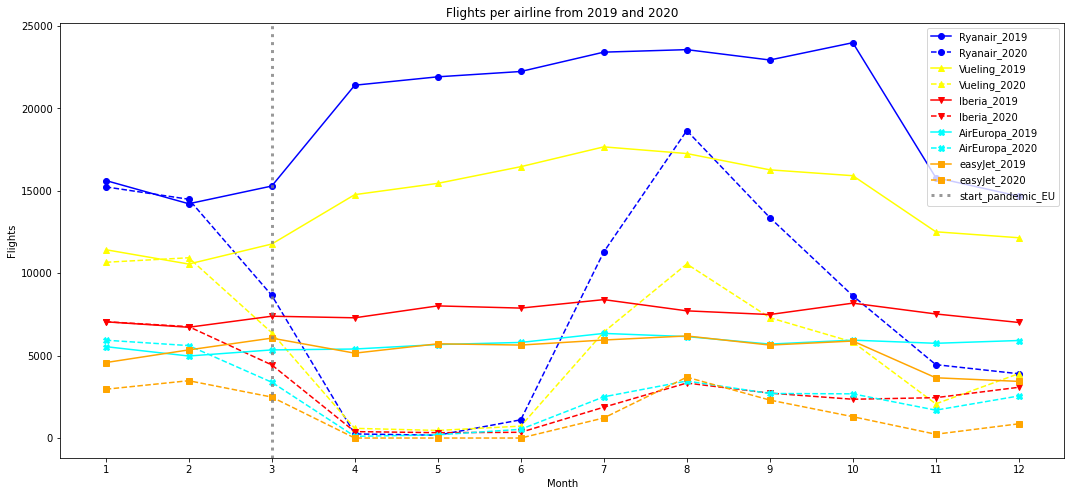

In [426]:
df_t_airlines_m = df_esp[(df_esp['year_']!=2021) & df_esp['airline'].isin(['Ryanair','Vueling Airlines', 'Iberia Airlines', 'Air Europa', 'easyJet UK'])]
t_airlines_m = pd.pivot_table(df_t_airlines_m,values='flights',index=['year_','month_'],columns=['airline'],aggfunc='sum').fillna(0)
t_airlines_m.reset_index(inplace=True)
t_airlines_m_19 = t_airlines_m.iloc[0:12]
t_airlines_m_20 = t_airlines_m.iloc[12:].reset_index()
plt.figure(figsize=(18,8))
plt.plot(t_airlines_m_19['month_'],t_airlines_m_19['Ryanair'],color='blue',label='Ryanair_2019',marker='o')
plt.plot(t_airlines_m_20['month_'],t_airlines_m_20['Ryanair'],color='blue',label='Ryanair_2020',ls='--',marker='o')
plt.plot(t_airlines_m_19['month_'],t_airlines_m_19['Vueling Airlines'],color='yellow',label='Vueling_2019',marker='^')
plt.plot(t_airlines_m_20['month_'],t_airlines_m_20['Vueling Airlines'],color='yellow',label='Vueling_2020',ls='--',marker='^')
plt.plot(t_airlines_m_19['month_'],t_airlines_m_19['Iberia Airlines'],color='red',label='Iberia_2019',marker='v')
plt.plot(t_airlines_m_20['month_'],t_airlines_m_20['Iberia Airlines'],color='red',label='Iberia_2020',ls='--',marker='v')
plt.plot(t_airlines_m_19['month_'],t_airlines_m_19['Air Europa'],color='cyan',label='AirEuropa_2019',marker='X')
plt.plot(t_airlines_m_20['month_'],t_airlines_m_20['Air Europa'],color='cyan',label='AirEuropa_2020',ls='--',marker='X')
plt.plot(t_airlines_m_19['month_'],t_airlines_m_19['easyJet UK'],color='orange',label='easyJet_2019',marker='s')
plt.plot(t_airlines_m_20['month_'],t_airlines_m_20['easyJet UK'],color='orange',label='easyJet_2020',ls='--',marker='s')
plt.title('Flights per airline from 2019 and 2020')
plt.ylabel('Flights')
plt.xlabel('Month')
plt.xticks(t_airlines_m_20['month_'])
plt.axvline(x=3,color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
plt.legend();

Se identifica que durante el mes de **Febrero de 2020** ya empezamos a tener una decadencia de los vuelos, decreciendo aún más sensiblemente en **Marzo de 2020** debido presumiblemente al aumento de casos COVID-19 que derivaron tanto en un miedo social generalizado como un aumento de las restricciones legales respecto al movimiento de personas en Europa provocando ambos efectos una caída histórica en el tráfico aéreo tanto a nivel Europa como España.

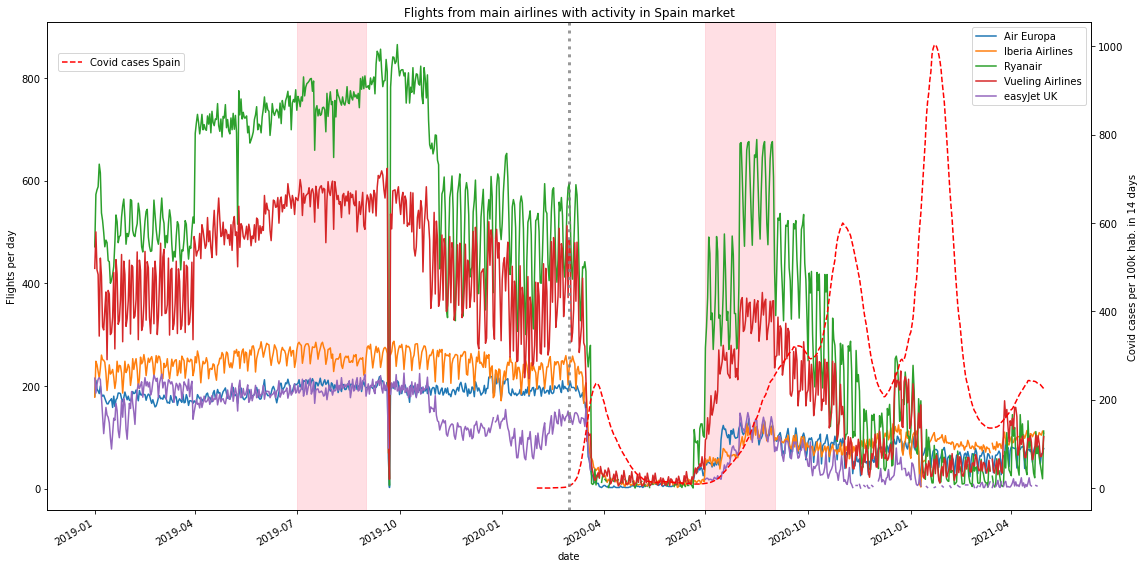

In [430]:
df_t_airlines_m = df_esp[df_esp['airline'].isin(['Ryanair','Vueling Airlines', 'Iberia Airlines', 'Air Europa', 'easyJet UK'])]
df_t_airlines_d = pd.pivot_table(df_t_airlines_m,values='flights',index=['date'],columns=['airline'],aggfunc='sum')

table_airlines =  pd.concat([df_t_airlines_d,df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
ax = table_airlines.drop('cases_14d_100k_hab_esp',axis=1).plot(figsize=(16,8))
ax2 = ax.twinx()
table_airlines['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights from main airlines with activity in Spain market")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.01,0.9))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

En el anterior gráfico, se analiza la cantidad de vuelos de las principales aerolíneas que operan en España a la par que se muestra la evolución de casos COVID-19. A grandes rasgos, se observa una caída brusca de los vuelos en todo el segundo trimestre de 2020 debido a los motivos previamente mencionados. Asimismo, se destaca (sombreado rojo) el periodo estival donde se puede observar una recuperación del tráfico aéreo probablemente motivada por una disminución de la incidencia del virus.
De igual manera, a partir de Octubre 2020 se vuelven a disparar los casos en lo que localmente se conoce como "la segunda ola" disminuyendo nuevamente el tráfico aéreo. Finalmente, en el mes de Diciembre 2020 volvemos a encontrar un aumento en el número de vuelos al que prosigue "la tercera ola", ambos probablemente debidos al reencuentro familiar habitual en Navidad y la mayor incidencia del virus a raíz del aumento en estos encuentros sociales.

## Flights from and to Spain by continent and country

Otro punto importante a analizar es el comportamiento en el origen de los vuelos con destino a España así como el destino de los vuelos con origen en el país. Se muestra a continuación un detalle por país/continente.

In [5]:
df_routes = df_esp.copy()

In [6]:
df_routes.head()

,date,latitude_1,longitude_1,latitude_2,longitude_2,airline,airline_country,origin_region,destination_region,origin_city,destination_city,origin_continent,origin_country,destination_continent,destination_country,year_,month_,day_,flights
0,2019-01-01,-37.692123,144.841997,41.036124,2.063557,Air China,China,Victoria,Catalonia,Melbourne,Barcelona,Oceania,Australia,Europe,Spain,2019,1,1,1
1,2019-01-02,60.626541,41.002776,40.483418,-3.546173,Air China,China,Arkhangelskaya,Madrid,Podyuga,Madrid,Europe,Russian Federation,Europe,Spain,2019,1,2,1
2,2019-01-02,40.535614,-3.558960,54.301835,90.041282,Air China,China,Madrid,Khakasiya,Madrid,Tuim,Europe,Spain,Europe,Russian Federation,2019,1,2,1
3,2019-01-03,58.353378,42.201942,40.486237,-3.549037,Air China,China,Kostroma,Madrid,Galich,Madrid,Europe,Russian Federation,Europe,Spain,2019,1,3,1
4,2019-01-04,-37.690430,144.841705,41.064423,2.037415,Air China,China,Victoria,Catalonia,Melbourne,Barcelona,Oceania,Australia,Europe,Spain,2019,1,4,1


In [7]:
def continent_A(df):
    if df['origin_country']=='Spain':
        return df['origin_continent']
    else:
        return df['destination_continent']
    
def country_A(df):
    if df['origin_country']=='Spain':
        return df['origin_country']
    else:
        return df['destination_country']

def region_A(df):
    if df['origin_country']=='Spain':
        return df['origin_region']
    else:
        return df['destination_region']
    
def city_A(df):
    if df['origin_country']=='Spain':
        return df['origin_city']
    else:
        return df['destination_city']

######

def continent_B(df):
    if df['origin_country']!='Spain':
        return df['origin_continent']
    else:
        return df['destination_continent']
    
def country_B(df):
    if df['origin_country']!='Spain':
        return df['origin_country']
    else:
        return df['destination_country']

def region_B(df):
    if df['origin_country']!='Spain':
        return df['origin_region']
    else:
        return df['destination_region']
    
def city_B(df):
    if df['origin_country']!='Spain':
        return df['origin_city']
    else:
        return df['destination_city']

In [9]:
df_routes['continent_A'] = df_routes.apply(continent_A,axis=1)
df_routes['country_A']= df_routes.apply(country_A,axis=1)
df_routes['region_A']= df_routes.apply(region_A,axis=1)
df_routes['city_A']= df_routes.apply(city_A,axis=1)
df_routes['continent_B']= df_routes.apply(continent_B,axis=1)
df_routes['country_B']= df_routes.apply(country_B,axis=1)
df_routes['region_B']= df_routes.apply(region_B,axis=1)
df_routes['city_B']= df_routes.apply(city_B,axis=1)

In [129]:
df_routes.drop(['latitude_1','longitude_1','latitude_2','longitude_2',
                'origin_region','destination_region','origin_city','destination_city','origin_continent',
                'origin_country','destination_continent','destination_country'],axis=1,inplace=True)

In [130]:
df_routes = df_routes[df_routes['country_B']!='Spain']
df_routes.reset_index(drop=True,inplace=True)

In [131]:
df_routes

,date,airline,airline_country,year_,month_,day_,flights,continent_A,country_A,region_A,city_A,continent_B,country_B,region_B,city_B
0,2019-01-01,Air China,China,2019,1,1,1,Europe,Spain,Catalonia,Barcelona,Oceania,Australia,Victoria,Melbourne
1,2019-01-02,Air China,China,2019,1,2,1,Europe,Spain,Madrid,Madrid,Europe,Russian Federation,Arkhangelskaya,Podyuga
2,2019-01-02,Air China,China,2019,1,2,1,Europe,Spain,Madrid,Madrid,Europe,Russian Federation,Khakasiya,Tuim
3,2019-01-03,Air China,China,2019,1,3,1,Europe,Spain,Madrid,Madrid,Europe,Russian Federation,Kostroma,Galich
4,2019-01-04,Air China,China,2019,1,4,1,Europe,Spain,Catalonia,Barcelona,Oceania,Australia,Victoria,Melbourne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579800,2021-04-28,Aie Experience Flight,United Kingdom,2021,4,28,1,Europe,Spain,Madrid,Getafe,Europe,France,Provence-Alpes-Cote d'Azur,Istres/Le Tubé
1579801,2021-04-28,Aernord,Italy,2021,4,28,1,Europe,Spain,Madrid,Getafe,Europe,France,Provence-Alpes-Cote d'Azur,Istres/Le Tubé
1579802,2021-04-17,Mandarin Air,China,2021,4,17,1,Europe,Spain,Balearic Islands,Palma De Mallorca,Europe,Latvia,Babite,Riga
1579803,2021-04-18,Mandarin Air,China,2021,4,18,1,Europe,Spain,Balearic Islands,Palma De Mallorca,Europe,Switzerland,Geneva,Geneva


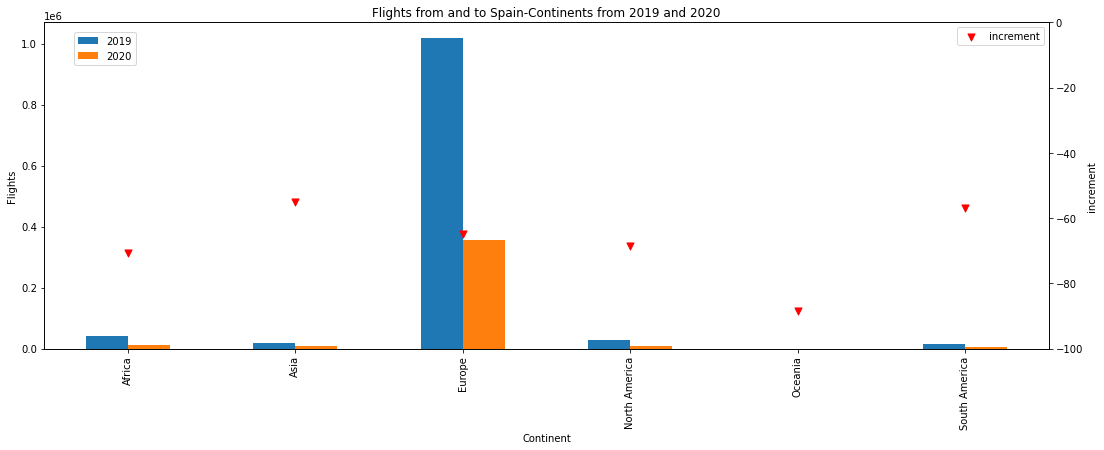

In [87]:
df_desti = df_routes[(df_routes['year_']!=2021)]
table_desti_con = pd.pivot_table(df_desti,values='flights',index=['continent_B'],columns=['year_'],aggfunc='sum').fillna(0)
table_desti_con.reset_index(inplace=True)
table_desti_con['increment'] = np.round(((table_desti_con[2020]-table_desti_con[2019])/table_desti_con[2019])*100,2)
ax_table_desti_con = table_desti_con.plot.bar(x='continent_B',y=[2019,2020],figsize=(18,6))
ax_table_desti_con.set_ylabel("Flights",)
ax_table_desti_con.set_xlabel("Continent",)
ax_table_desti_con.set_title('Flights from and to Spain-Continents from 2019 and 2020')
ax2 = ax_table_desti_con.twinx()
table_desti_con.plot(x='continent_B',y='increment',ax=ax2,kind='scatter',color='r',label='increment', marker='v',s=50,)
ax_table_desti_con.legend(loc=(0.03,0.87))
ax2.set_ylim([-100,0])
ax2.legend(loc=0);

Se identifica que independientemente del continente de origen/destino, a pesar de tener incidencias de COVID-19 distintos en cada uno de ellos, el tráfico aéreo ha disminuido más del 50% en cualquiera sea el continente, acentuándose aún más sensiblemente en Oceania (~ -90%) y África (~ -70%).

A continuación se realiza también por país una comparativa de vuelos desde España a sus principales destinos y orígenes:

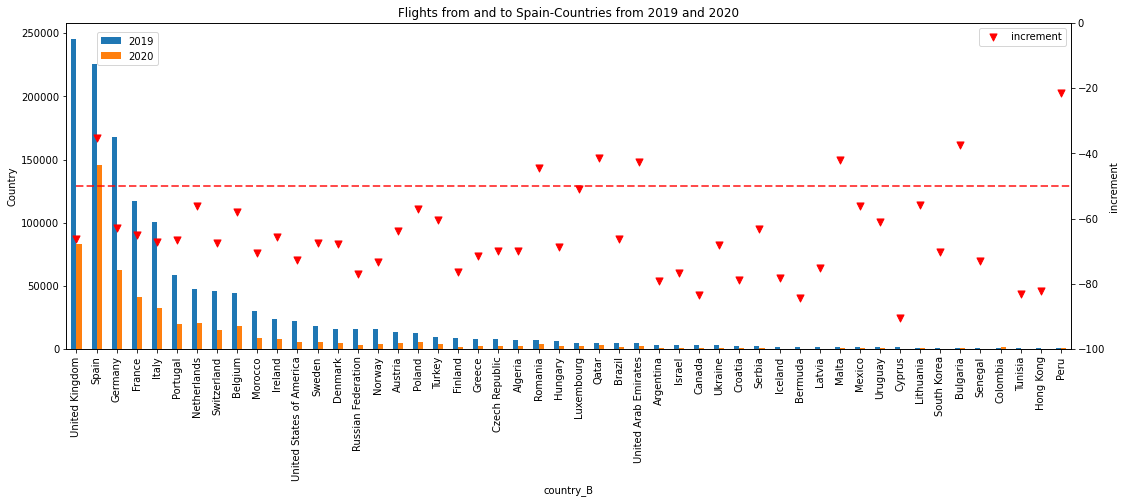

In [27]:
df_desti = df_routes[(df_routes['year_']!=2021)]
table_desti_con = pd.pivot_table(df_desti,values='flights',index=['country_B'],columns=['year_'],aggfunc='sum').fillna(0)
table_desti_con = table_desti_con.sort_values(2019,ascending=False).iloc[0:50].fillna(0)
table_desti_con.reset_index(inplace=True)
table_desti_con['increment'] = np.round(((table_desti_con[2020]-table_desti_con[2019])/table_desti_con[2019])*100,2)
ax_table_desti_con = table_desti_con.plot.bar(x='country_B',y=[2019,2020],figsize=(18,6))
ax_table_desti_con.set_ylabel("Flights",)
ax_table_desti_con.set_ylabel("Country",)
ax_table_desti_con.set_title('Flights from and to Spain-Countries from 2019 and 2020')
ax2 = ax_table_desti_con.twinx()
table_desti_con.plot(x='country_B',y='increment',ax=ax2,kind='scatter',color='r',label='increment', marker='v',s=50,)
ax_table_desti_con.legend(loc=(0.03,0.87))
ax2.set_ylim([-100,0])
ax2.legend(loc=0)
ax2.hlines(y=-50, xmin=0, xmax=len(table_desti_con), linewidth=2, color='r',linestyles='--',alpha=0.7);

Observando el comportamiento de los principales países con los que España comparte tráfico aéreo, también se identifica, tal como se mostraba en el análisis por compañía aérea, una gran mayoría de rutas aéreas con un decremento inferior al -50% en número de vuelos respecto al año anterior.

A continuación se centra el foco en los seis principales países que más tráfico aéreo tienen en España, para los que además disponemos datos de impacto COVID-19, estos son: **Reino Unido, Alemania, Francia, Italia, Portugal y Países Bajos**. 

In [39]:
countries_cov = ['Spain'] + list(table_desti_con['country_B'].iloc[0:6])
countries_cov

['Spain', 'United Kingdom', 'Spain', 'Germany', 'France', 'Italy', 'Portugal']

In [40]:
table_desti_con_uk = pd.pivot_table(df_routes[df_routes['country_B'].isin(['United Kingdom of Great Britain & Northern Ireland','United Kingdom'])]
                                    ,values='flights',index=['date'],aggfunc='sum').fillna(0)
table_desti_con_gr = pd.pivot_table(df_routes[df_routes['country_B'].isin(['Germany'])],values='flights',index=['date'],aggfunc='sum').fillna(0)
table_desti_con_fr = pd.pivot_table(df_routes[df_routes['country_B'].isin(['France'])],values='flights',index=['date'],aggfunc='sum').fillna(0)
table_desti_con_it = pd.pivot_table(df_routes[df_routes['country_B'].isin(['Italy'])],values='flights',index=['date'],aggfunc='sum').fillna(0)
table_desti_con_pt = pd.pivot_table(df_routes[df_routes['country_B'].isin(['Portugal'])],values='flights',index=['date'],aggfunc='sum').fillna(0)
table_desti_con_nt = pd.pivot_table(df_routes[df_routes['country_B'].isin(['Netherlands'])],values='flights',index=['date'],aggfunc='sum').fillna(0)

table_desti_con_uk = pd.concat([table_desti_con_uk,df_covid_eu['cases_14d_100k_hab_uk'],df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
table_desti_con_gr = pd.concat([table_desti_con_gr,df_covid_eu['cases_14d_100k_hab_gr'],df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
table_desti_con_fr = pd.concat([table_desti_con_fr,df_covid_eu['cases_14d_100k_hab_fr'],df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
table_desti_con_it = pd.concat([table_desti_con_it,df_covid_eu['cases_14d_100k_hab_it'],df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
table_desti_con_pt = pd.concat([table_desti_con_pt,df_covid_eu['cases_14d_100k_hab_pt'],df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
table_desti_con_nt = pd.concat([table_desti_con_nt,df_covid_eu['cases_14d_100k_hab_nt'],df_covid_eu['cases_14d_100k_hab_esp']],axis=1)

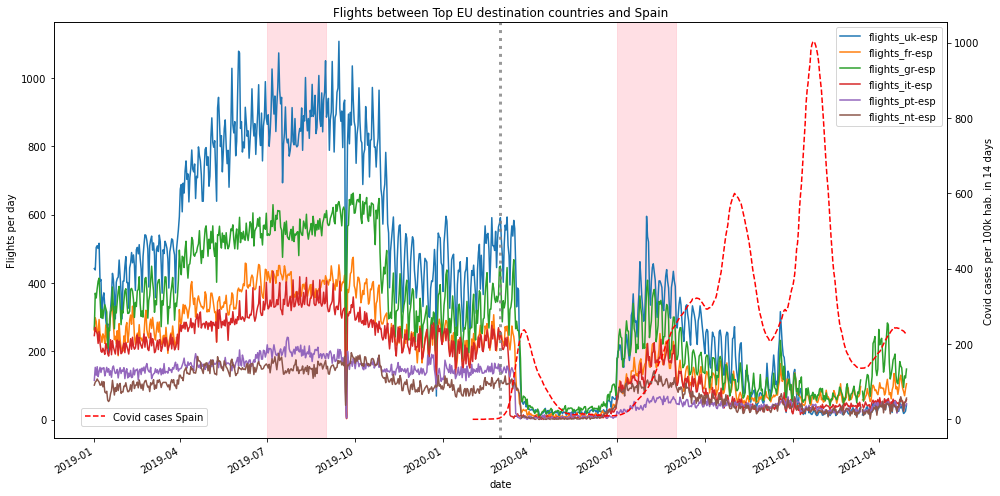

In [43]:
ax = table_desti_con_uk['flights'].plot(label='flights_uk-esp',figsize=(14,7))
table_desti_con_fr['flights'].plot(label='flights_fr-esp',ax=ax)
table_desti_con_gr['flights'].plot(label='flights_gr-esp',ax=ax)
table_desti_con_it['flights'].plot(label='flights_it-esp',ax=ax)
table_desti_con_pt['flights'].plot(label='flights_pt-esp',ax=ax)
table_desti_con_nt['flights'].plot(label='flights_nt-esp',ax=ax)
ax2 = ax.twinx()
table_desti_con_uk['cases_14d_100k_hab_esp'].plot(x='date',color='red',label='Covid cases Spain',style='--',ax=ax2)
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between Top EU destination countries and Spain")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.03,0.03))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

Como se ha comentado anteriormente, el comportamiento país a país es similar, una caída brusca en el segundo trimestre de 2020 debido a las restricciones e incertidumbre causadas por el COVID-19, una relajación de la incidencia del virus en verano que da pie a un aumento en el número de vuelos aunque a niveles lejanos a los del verano 2020 así como el impacto de la segunda y tercera ola a finales de 2020 e inicios de 2021 donde se vuelve a dar una disminución en el número de vuelos.

Asimismo, se procede a continuación a dar más detalle país a país para tener mejor visibilidad y ver también los casos COVID-19 de cada país en cuestión y su tráfico aéreo.

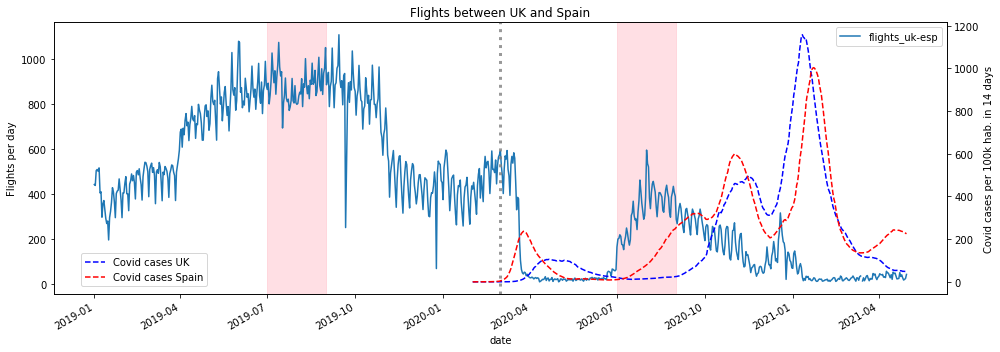

In [436]:
ax = table_desti_con_uk['flights'].plot(label='flights_uk-esp',figsize=(14,5))
ax2 = ax.twinx()
table_desti_con_uk['cases_14d_100k_hab_uk'].plot(x='date',color='blue',style='--',ax=ax2,label='Covid cases UK')
table_desti_con_uk['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between UK and Spain")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.03,0.03))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

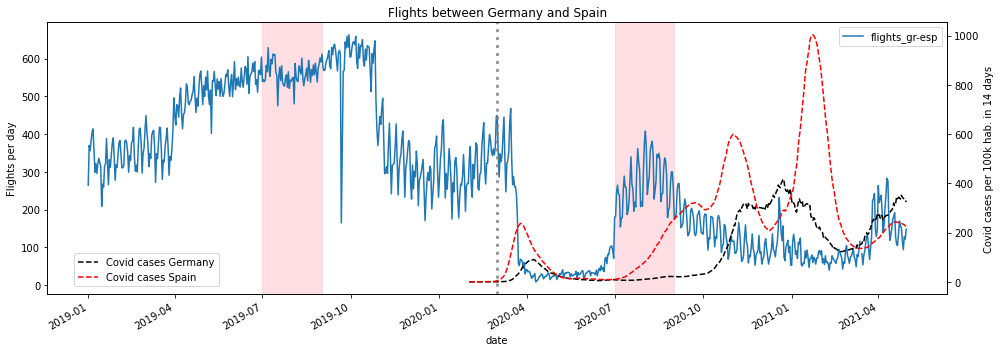

In [437]:
ax = table_desti_con_gr['flights'].plot(label='flights_gr-esp',figsize=(14,5))
ax2 = ax.twinx()
table_desti_con_gr['cases_14d_100k_hab_gr'].plot(x='date',color='black',style='--',ax=ax2,label='Covid cases Germany')
table_desti_con_gr['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between Germany and Spain")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.03,0.03))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

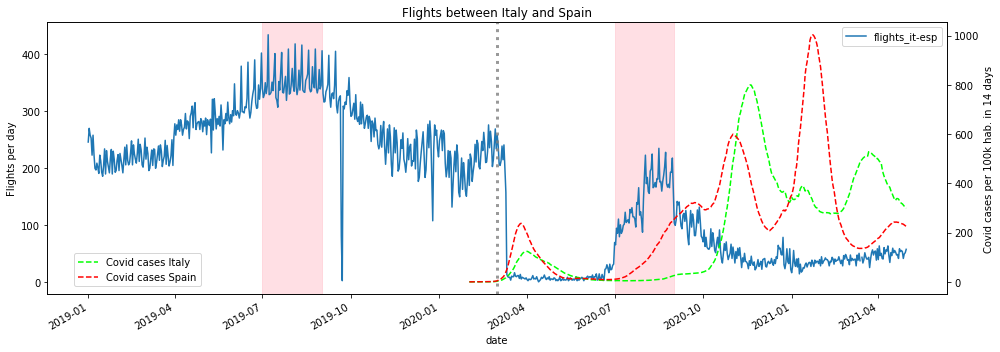

In [438]:
ax = table_desti_con_it['flights'].plot(label='flights_it-esp',figsize=(14,5))
ax2 = ax.twinx()
table_desti_con_it['cases_14d_100k_hab_it'].plot(x='date',color='lime',style='--',ax=ax2,label='Covid cases Italy')
table_desti_con_it['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between Italy and Spain")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.03,0.03))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

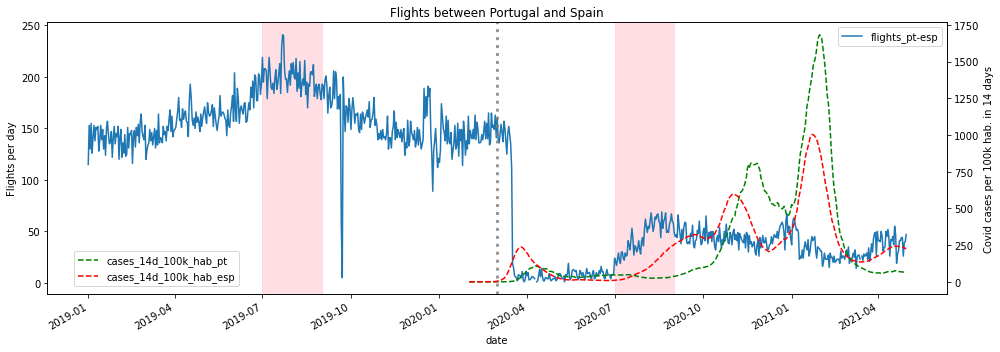

In [287]:
ax = table_desti_con_pt['flights'].plot(label='flights_pt-esp',figsize=(14,5))
ax2 = ax.twinx()
table_desti_con_pt['cases_14d_100k_hab_pt'].plot(x='date',color='green',style='--',ax=ax2,label='Covid cases Portugal')
table_desti_con_pt['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between Portugal and Spain")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.03,0.03))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

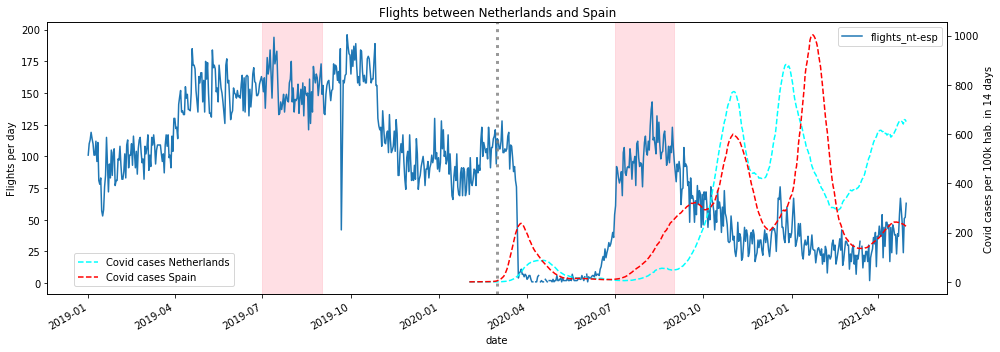

In [439]:
ax = table_desti_con_nt['flights'].plot(label='flights_nt-esp',figsize=(14,5))
ax2 = ax.twinx()
table_desti_con_nt['cases_14d_100k_hab_nt'].plot(x='date',color='cyan',style='--',ax=ax2,label='Covid cases Netherlands')
table_desti_con_nt['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between Netherlands and Spain")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.03,0.03))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

Todo parece indicar que, generalmente, los principales países europeos han mostrado el mismo comportamiento que llevamos viendo durante el análisis, sin diferencias significativas ni en términos de incidencia del virus ni en el tráfico aéreo.

A continuación, se añade una capa más de profunidad analizando el tráfico aéreo entre Reino Unido, el país con más vuelos con España, y las principales comunidades autónomas de España para verificar si además del impacto identificado en el número de vuelos, la incidencia del COVID-19 ha afectado de manera distinta a las regiones de España.

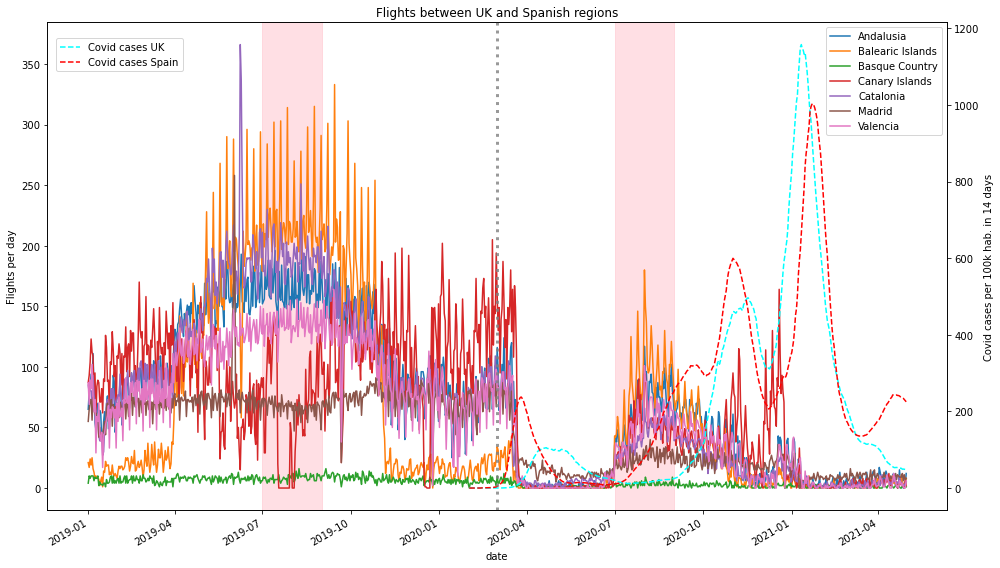

In [44]:
df_routes_reg = df_routes[df_routes['region_A'].isin(['Andalusia','Balearic Islands','Basque Country','Canary Islands','Catalonia','Madrid','Valencia'])]
table_desti_con_uk_reg = pd.pivot_table(df_routes_reg[df_routes_reg['country_B'].isin(['United Kingdom of Great Britain & Northern Ireland','United Kingdom'])]
                                    ,columns=['region_A'],values='flights',index=['date'],aggfunc='sum').fillna(0)

ax = table_desti_con_uk_reg.plot(figsize=(14,8))
ax2 = ax.twinx()
table_desti_con_uk['cases_14d_100k_hab_uk'].plot(x='date',color='cyan',style='--',ax=ax2,label='Covid cases UK')
table_desti_con_uk['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between UK and Spanish regions")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.01,0.9))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

Como se observa en el gráfico, todas las regiones se comportan de manera similar a lo visto hasta ahora en el análisis por aerolínea/continente/país aunque si se destaca por ejemplo el aumento de vuelos a Canarias en los meses de Noviembre 2020 a Enero 2021 mientras que el resto de comunidades, incluidas las Islas Baleares, disminuyen su tráfico aéreo.
Para poner en contexto, cabe destacar que los casos diarios de COVID-19 en España a principios de Enero 2021 eran alrededor de 35.000 mientras que en Canarias estaban alrededor de solamente 300 casos diarios lo que probablemente favoreció viajar a este destino.

## Internal air transport

Por último, se analizará el transporte aéreo doméstico español, esto es, los vuelos con origen y destino en España.

In [10]:
df_esp_reg = df_esp[(df_esp['origin_country']=='Spain') 
                    & (df_esp['destination_country']=='Spain') 
                    & (df_esp['origin_region']!=df_esp['destination_region'])]
df_esp_reg.reset_index(drop=True,inplace=True)
df_esp_reg.fillna('',inplace=True)
df_esp_reg['route_reg'] = df_esp_reg[['origin_region', 'destination_region']].agg('-'.join, axis=1)


C:\Users\AL191\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-10-3f82afda9c25>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_esp_reg['route_reg'] = df_esp_reg[['origin_region', 'destination_region']].agg('-'.join, axis=1)


In [11]:
def order_region(x):
    l = x.split('-')
    r = min(l)+'-'+max(l)
    return r

In [12]:
df_esp_reg['route_reg'] = df_esp_reg['route_reg'].apply(order_region)

<ipython-input-12-672bad830017>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_esp_reg['route_reg'] = df_esp_reg['route_reg'].apply(order_region)


In [13]:
df_esp_reg

,date,latitude_1,longitude_1,latitude_2,longitude_2,airline,airline_country,origin_region,destination_region,origin_city,destination_city,origin_continent,origin_country,destination_continent,destination_country,year_,month_,day_,flights,route_reg
0,2019-01-01,42.288798,-12.555776,40.482804,-3.545588,Air Europa,Spain,Galicia,Madrid,Fisterra,Madrid,Europe,Spain,Europe,Spain,2019,1,1,1,Galicia-Madrid
1,2019-01-01,40.519766,-3.574864,30.575409,-14.465063,Air Europa,Spain,Madrid,Canary Islands,Madrid,Tinajo,Europe,Spain,Europe,Spain,2019,1,1,1,Canary Islands-Madrid
2,2019-01-01,39.478500,2.569368,39.524479,0.529602,Air Europa,Spain,Balearic Islands,Valencia,Magaluf,Orpesa/Oropesa del Mar,Europe,Spain,Europe,Spain,2019,1,1,1,Balearic Islands-Valencia
3,2019-01-01,40.516891,-3.574890,28.524232,-16.466998,Air Europa,Spain,Madrid,Canary Islands,Madrid,Tenerife,Europe,Spain,Europe,Spain,2019,1,1,1,Canary Islands-Madrid
4,2019-01-01,40.524701,-3.559445,41.320038,1.512573,Air Europa,Spain,Madrid,Catalonia,Madrid,la Bisbal del Penedes,Europe,Spain,Europe,Spain,2019,1,1,1,Catalonia-Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358174,2021-04-14,37.417897,-5.900494,40.278259,-3.744568,Aernord,Italy,Andalusia,Madrid,Sevilla,Getafe,Europe,Spain,Europe,Spain,2021,4,14,1,Andalusia-Madrid
358175,2021-04-15,40.278946,-3.742615,37.417786,-5.962654,Aerotrans Airlines,Russia,Madrid,Andalusia,Getafe,Sevilla,Europe,Spain,Europe,Spain,2021,4,15,1,Andalusia-Madrid
358176,2021-04-15,40.278946,-3.742615,37.417786,-5.962654,Aie Experience Flight,United Kingdom,Madrid,Andalusia,Getafe,Sevilla,Europe,Spain,Europe,Spain,2021,4,15,1,Andalusia-Madrid
358177,2021-04-15,40.278946,-3.742615,37.417786,-5.962654,Aernord,Italy,Madrid,Andalusia,Getafe,Sevilla,Europe,Spain,Europe,Spain,2021,4,15,1,Andalusia-Madrid


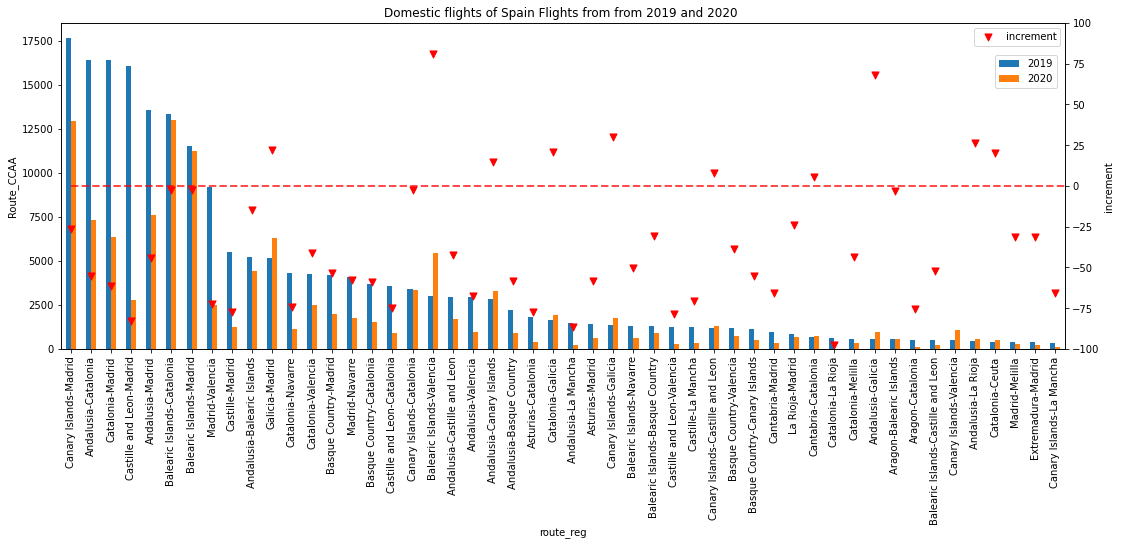

In [19]:
table_esp_reg_t = pd.pivot_table(df_esp_reg[df_esp_reg['year_']!=2021],index=['route_reg'],
                                 columns=['year_'],values='flights',
                                 aggfunc='sum').fillna(0).sort_values(by=2019,ascending=False).iloc[0:50].fillna(0)
table_esp_reg_t.reset_index(inplace=True)
table_esp_reg_t['increment'] = np.round(((table_esp_reg_t[2020]-table_esp_reg_t[2019])/table_esp_reg_t[2019])*100,2)
ax_table_esp_reg_t = table_esp_reg_t.plot.bar(x='route_reg',y=[2019,2020],figsize=(18,6))
ax_table_esp_reg_t.set_ylabel("Flights",)
ax_table_esp_reg_t.set_ylabel("Route_CCAA",)
ax_table_esp_reg_t.set_title('Domestic flights of Spain Flights from from 2019 and 2020 ')
ax2 = ax_table_esp_reg_t.twinx()
table_esp_reg_t.plot(x='route_reg',y='increment',ax=ax2,kind='scatter',color='r',label='increment', marker='v',s=50,)
ax_table_esp_reg_t.legend(loc=(0.93,0.8))
ax2.set_ylim([-100,100])
ax2.legend(loc=0);
ax2.hlines(y=0, xmin=0, xmax=len(table_esp_reg_t), linewidth=2, color='r',linestyles='--',alpha=0.7);

En esta representación se puede observar las distintas rutas españolas y su variación en número de vuelos entre 2019 y 2020.
Primeramente se observa, como era de esperar, que la mayoría de rutas decrecen en número de vuelos aunque también destacamos que ciertas rutas que no presentaban tanta actividad en 2019 con motivo del Covid han aumentado significativamente.

Se podrían encontrar varios motivos para estas casuísticas, por una parte, hay que recordar que cada comunidad autónoma, una vez finalizado el toque de queda impuesto en Marzo-Mayo 2020, ha impuesto su regulación de manera particular en cuanto a la mobilidad de personas. El resultado fue que diversas comunidades tuvieran un cierre perimetral vigente mientras que otras, en ese mismo periodo, no. Por ejemplo, en Noviembre 2020 un residente de Madrid podía coger libremente un vuelo a Galicia pero no podía viajar a Castilla y León. Este ejemplo se puede ver reflejado en el gráfico donde se observa que la ruta Madrid-Castilla y León disminuye prácticamente en -80% mientras que la ruta Madrid-Galicia aumenta en +25%.
Además del factor regulatorio, en general los vuelos con destino Islas Canarias o Islas Baleares han aumentado motivado probablemente por las restricciones que se daban a la población española para viajar al resto de Europa.

In [20]:
table_esp_reg_t[table_esp_reg_t['increment']>-5]

year_,route_reg,2019,2020,increment
5,Balearic Islands-Catalonia,13356.0,13042.0,-2.35
6,Balearic Islands-Madrid,11552.0,11259.0,-2.54
10,Galicia-Madrid,5167.0,6292.0,21.77
17,Canary Islands-Catalonia,3439.0,3363.0,-2.21
18,Balearic Islands-Valencia,3024.0,5479.0,81.18
21,Andalusia-Canary Islands,2848.0,3274.0,14.96
24,Catalonia-Galicia,1622.0,1955.0,20.53
27,Canary Islands-Galicia,1349.0,1755.0,30.10
32,Canary Islands-Castille and Leon,1210.0,1306.0,7.93
37,Cantabria-Catalonia,687.0,726.0,5.68


Seguiremos ahora con el comportamiento en el cronograma de vuelos por cada comunidad autónoma:

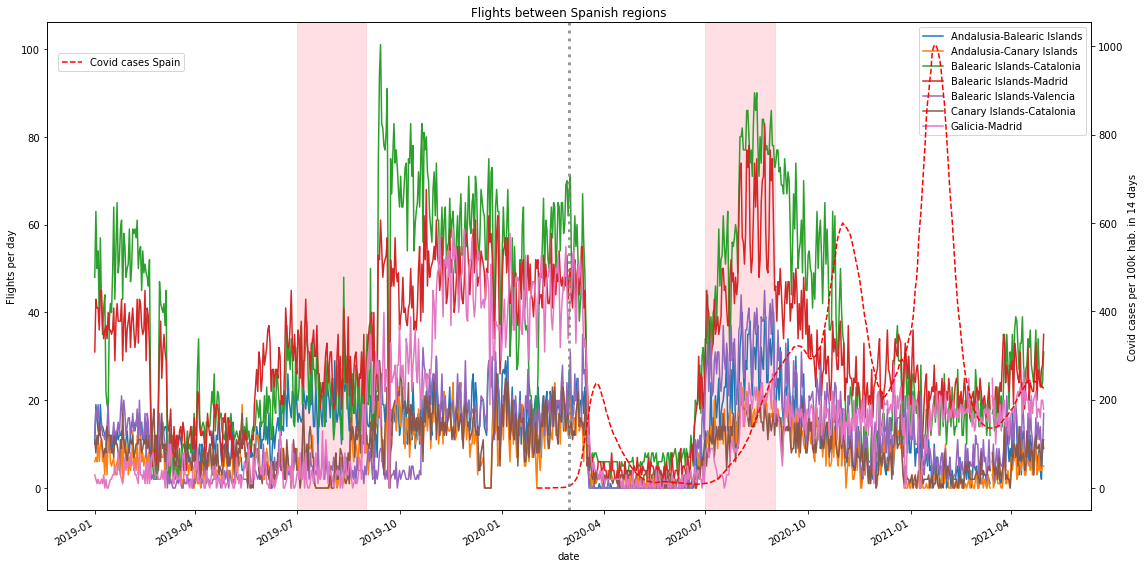

In [26]:
visited_ccaa = table_esp_reg_t['route_reg'][(table_esp_reg_t['increment']>-15) & (table_esp_reg_t[2020]>3000)]
table_esp_reg = pd.pivot_table(df_esp_reg[df_esp_reg['route_reg'].isin(visited_ccaa)],columns=['route_reg'],values='flights',index=['date'],aggfunc='sum').fillna(0)
table_esp_reg =  pd.concat([table_esp_reg,df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
ax = table_esp_reg.drop('cases_14d_100k_hab_esp',axis=1).plot(figsize=(16,8))
ax2 = ax.twinx()
table_esp_reg['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between Spanish regions")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.01,0.9))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

Finalmente, una vez más, observamos que para las principales rutas españolas presentan un comportamiento respecto al COVID-19 similar al visto en el resto de análisis hasta ahora aunque destacamos el aumento de las rutas hacia las islas en verano probablemente debido al motivo que compartíamos previamente, una mayor afluencia del turismo nacional hacia islas nacionales por las restricciones (cuarentena, PCR obligatoria, etc.) que hubieron en el verano de 2020 en el resto de países europeos.

## Final Conclusion

Una vez realizado todo el análisis, podemos proceder a responder a las cuestiones inicialmente planteadas:

**1. ¿Cómo ha impactado el virus del COVID-19 en el tráfico aéreo español?**

Como se ha podido observar en el análisis de vuelos por aerolínea/continente/país, el virus COVID-19 ha impactado negativamente en el tráfico aéreo comercial español de 2020 reduciendo su actividad en más del 50% respecto al mismo periodo del año 2019.

En febrero 2020 ya se empieza a identificar una ligera reducción en la actividad aérea que se agrava especialmente en los meses de marzo, abril y mayo de 2020. Esta disminución se puede explicar debido a la incertidumbre y el pánico social tanto de particulares como de gobiernos en cuanto al potencial impacto del COVID-19 que provocó unas medidas extremas en varios países de la Unión Europea como por ejemplo España donde se llevó a cabo un confinamiento estricto restrigiendo la movilidad aérea tanto exterior como interior únicamente a motivos justificados y de gravedad.

A principios de junio 2020 disminuye significativamente la incidencia del virus provocando así un aumento del tráfico aéreo en la temporada estival de 2020 en prácticamente todas las rutas habituales aunque sin llegar a los niveles de 2019. Asimismo, a finales de verano vuelve a aumentar la incidencia hasta llegar a la Segunda Ola sufrida en noviembre 2021 reduciendo nuevamente gran parte de la actividad aérea del país.

Finalmente, en el mes de Diciembre 2020 volvemos a encontrar un aumento en el número de vuelos debido al reencuentro familiar habitual en Navidad lo que provoca un posterior incremento en la incidencia del virus a raíz del aumento de encuentros sociales dados en Navidad. Esto a su vez, con un efecto de retroalimentación, provoca mayores restricciones en el transporte aéreo que hace disminuir la actividad hasta prácticamente abril 2021.

**2. ¿Ha impactado por igual a las rutas exteriores?**

Tal como se ha comentado previamente, las rutas exteriores a todos los continentes/países se han visto generalmente afectadas por el mismo patrón descrito en la cuestión 1. Poniendo el foco en los principales países europeos (Reino Unido, Francia, Alemania, Italia, Holanda y Portugal), hemos observado también que muestran un comportamiento similar tanto en el tráfico aéreo como en la incidencia del virus.

**3. ¿Cuál ha sido el comportamiento de los vuelos domésticos?**

Por último, en cuanto a los vuelos nacionales dentro de España, se ha observado que la mayoría de rutas habituales también han disminuido su actividad con un patrón similar al expuesto en la cuestión 1, aunque ciertas rutas menos habituales han aumentado su actividad debido probablemente por los motivos previamente expuestos, es decir, la presencia de mayores restricciones en los vuelos exteriores respecto a los nacionales provocando que parte de la población decidiera optar por un destino doméstico y una independencia regulatoria entre las distintas comunidades autónomas que resultaba en ciertas rutas de transporte accesibles a particulares por aire y restringidas por tierra.

Indicar también que en se ha subido un fichero Tableau con representaciones gráficas a nivel tanto estatal como regional que refuerzan estas mismas conclusiones.